# Introduction to PyImageJ

This notebook introduces how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including NumPy, SciPy, scikit-image, CellProfiler, OpenCV, ITK and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the other notebooks.

## 1 Starting ImageJ from Python

The [pyimagej](https://pypi.org/project/pyimagej/) module enables access to the entire ImageJ API from Python in a natural way.

Let's initialize an ImageJ gateway including Fiji plugins, at a reproducible version:

In [1]:
import imagej
ij = imagej.init('sc.fiji:fiji')
ij.getVersion()

'2.1.0/1.53c'

### Ways to initialize

| Requirement                                   | Code<sup>1</sup>                                                     | Reproducible?<sup>2</sup> |
|:----------------------------------------------|:---------------------------------------------------------------------|:-------------------------:|
| Newest available version of ImageJ            | `ij = imagej.init()`                                                 | NO                        |
| Specific version of ImageJ                    | `ij = imagej.init('net.imagej:imagej:2.0.0-rc-71')`                  | YES                       |
| With a GUI (newest version)                   | `ij = imagej.init(headless=False)`                                   | NO                        |
| With a GUI (specific version)                 | `ij = imagej.init('net.imagej:imageJ:2.0.0-rc-71', headless=False)`  | YES                       |
| With support for ImageJ 1.x (newest versions) | `ij = imagej.init('net.imagej:imagej+net.imagej:imagej-legacy')`     | NO                        |
| With Fiji plugins (newest version)            | `ij = imagej.init('sc.fiji:fiji')`                                   | NO                        |
| With Fiji plugins (specific version)          | `ij = imagej.init('sc.fiji:fiji:2.0.0-pre-10')`                      | YES                       |
| From a local installation                     | `ij = imagej.init('/Applications/Fiji.app')`                         | DEPENDS                   |

<sup>1</sup> pyimagej uses [`jgo`](https://github.com/scijava/jgo) internally to call up ImageJ, so all of these initializations are tied to the usage of `jgo`. You can read up on the [usage of `jgo`](https://github.com/scijava/jgo#usage) to find out more about this initialization.

<sup>2</sup> ___Reproducible___ means code is stable, executing the same today, tomorrow, and in years to come. While it is convenient and elegant to depend on the newest version of a program, behavior may change when new versions are released—for the better if bugs are fixed; for the worse if bugs are introduced—and people executing your notebook at a later time may encounter broken cells, unexpected results, or other more subtle behavioral differences. You can help avoid this pitfall by pinning to a specific version of the software. The British Ecological Society published [Guide to Better Science: Reproducible Code](https://www.britishecologicalsociety.org/wp-content/uploads/2018/12/BES-Reproducible-Code.pdf) diving into the relevant challenges in more detail, including an [R](https://www.r-project.org/)-centric illustration of best practices. A web search for `reproducible python` also yields several detailed articles.

### 1.2 Increasing the memory available to Java

Java's virtual machine (the JVM) has a "max heap" value limiting how much
memory it can use. You can increase it:

```python
import scyjava_config
scyjava_config.add_options('-Xmx6g')
import imagej
ij = imagej.init()
```

Replace `6g` with the amount of memory Java should have. You can also pass
[other JVM arguments](https://docs.oracle.com/javase/8/docs/technotes/tools/unix/java.html).

Without having specified the max heap value explicitly, here is how much memory this notebook's JVM has available:

In [2]:
ij.getApp().getInfo(True)

'ImageJ 2.1.0/1.53c; Java 11.0.8-internal [amd64]; 114MB of 8030MB'

## 2 Visualizing data

ImageJ can display numpy images using `ij.py.show`. Let's demonstrate using `scikit-image` to grab a sample:

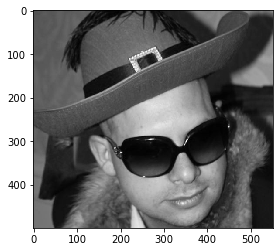

In [3]:
from skimage import io
import numpy as np
img = io.imread('https://samples.fiji.sc/new-lenna.jpg')
img = np.mean(img[500:1000,300:850], axis=2)
ij.py.show(img, cmap = 'gray')

`ij.py.show` is merely a convenience function using matplotlib.

## 3 Converting Python data to Java

The function `to_java` is capable of converting common Python data types into their Java/ImageJ equivalent.

Let's take a look at lists:

In [4]:
# Lists convert and handle simply
ex_list = [1, 2, 3, 4]
print(type(ex_list))
java_list = ij.py.to_java(ex_list)
print(type(java_list))

<class 'list'>
<java class 'java.util.ArrayList'>


A java list can be accessed the same as a python list. Changing values in the python list does not change values in the java list.

In [5]:
ex_list[0] = 4
java_list[0]

1

By contrast, ops can operate on numpy arrays and change them, though you need to wrap the arrays with `to_java` first.

In [6]:
import numpy as np

arr1 = np.array([[1, 2], [3, 4]])
arr2 = np.array([[5, 6], [7, 8]])
arr_output = ij.py.new_numpy_image(arr1)

ij.op().run('multiply', ij.py.to_java(arr_output), ij.py.to_java(arr1), ij.py.to_java(arr2))
arr_output

array([[ 5, 12],
       [21, 32]])

### 3.1 Process numpy arrays in ImageJ

`to_java` also works to convert numpy arrays into ImageJ types.

There is one important nuance: converting a numpy array to java creates a java object that points to the numpy array. This means that **changing the java object also changes the numpy array**.

Let's try it. First, we load an image:

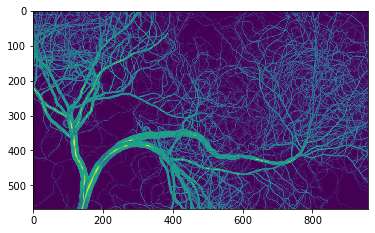

In [7]:
# Import an image with scikit-image.
# NB: Blood vessel image from: https://www.fi.edu/heart/blood-vessels
from skimage import io
url = 'https://www.fi.edu/sites/fi.live.franklinds.webair.com/files/styles/featured_large/public/General_EduRes_Heart_BloodVessels_0.jpg'
img = io.imread(url)
img = np.mean(img, axis=2)
ij.py.show(img)

Now we feed it to ImageJ difference-of-Gaussians op:

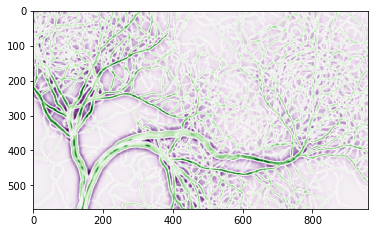

In [8]:
result = np.zeros(img.shape)
# these sigmas will be nice for the larger sections
sigma1 = 8
sigma2 = 2
# note the use of to_java on img and result to turn the numpy images into RAIs
ij.op().filter().dog(ij.py.to_java(result), ij.py.to_java(img), sigma1, sigma2)
# purple highlights the edges of the vessels, green highlights the centers
ij.py.show(result, cmap = 'PRGn')

## 4 Send an ImageJ image into NumPy

`from_java` works in reverse of `to_java` and can be used to further process ImageJ data types with numpy, scikit-image, etc. 

Open an image from the url using the ImageJ scripting interface and then send it to a numpy array.

[java.lang.Enum.toString] 14:06:37.000 [main] DEBUG org.scijava.nativelib.BaseJniExtractor - Not deleting leftover folder /tmp/nativelib-loader_5473431581712047711: is 53567ms old
[java.lang.Enum.toString] 14:06:37.001 [main] DEBUG org.scijava.nativelib.BaseJniExtractor - Not deleting leftover folder /tmp/nativelib-loader_6681031414841972184: is 47836ms old
[java.lang.Enum.toString] 14:06:37.001 [main] DEBUG org.scijava.nativelib.BaseJniExtractor - Not deleting leftover folder /tmp/nativelib-loader_14768070301380027696: is 50656ms old
[java.lang.Enum.toString] 14:06:37.002 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - processor is INTEL_64 os.arch is amd64
[java.lang.Enum.toString] 14:06:37.002 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is LINUX_64 os.name is linux
[java.lang.Enum.toString] 14:06:37.002 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is LINUX_64 os.name is linux
[java.lang.Enum.toString] 14:06:37.002 [main] DEBUG or

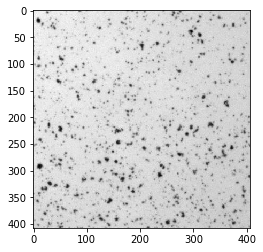

In [9]:
url_colony = 'https://wsr.imagej.net/images/Cell_Colony.jpg'

# Load the image
cell_colony = ij.io().open(url_colony)

# Send it to numpy
numpy_colony = ij.py.from_java(cell_colony)

# Display the image
ij.py.show(numpy_colony, cmap='gray')

### Special Consideration: RGB and other axis conventions

NumPy is reverse indexed from ImageJ, e.g. axis order in numpy is ZYX and in ImageJ is (by default) XYZ.  In addition, numpy and matplotlib have a limited understanding of axis conventions and only natively handle 3-channel RGB images as YXC. To handle this, ImageJ images are converted to rich xarray data, with axes retaining their metadata and properly re-ordered.


In [10]:
# load the image into IJ
ij_img = ij.io().open('https://samples.fiji.sc/new-lenna.jpg')

# Convert the image to a numpy array
img_from_ij = ij.py.from_java(ij_img)

np.shape(img_from_ij)

[java.lang.Enum.toString] [INFO] Populating metadata


(1279, 853, 3)

Note that the channel dimension comes last. The image can be plotted directly:

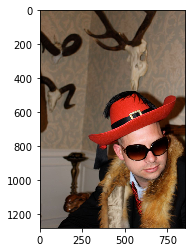

In [11]:
# Hint: There are two barriers to plotting the image: the axis order, and that matplotlib only plot 8-bit RGB images
# convert to 8-bit
img_as_8bit = img_from_ij.astype(int)
# plot the image (xarr)
ij.py.show(img_as_8bit)